In [ ]:
# 참조 사이트
# https://www.kaggle.com/andreshg/timeseries-analysis-a-complete-guide

In [ ]:
!pip install pmdarima

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from colorama import Fore
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import warnings
warnings.filterwarnings('ignore')
np.random.seed(7)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Kaggle/Aquifer_Petrignano/Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(5223, 8)

In [ ]:
# Remove old rows
df = df[df['Rainfall_Bastia_Umbra'].notna()].reset_index(drop=True)
# 사용 안하는 컬럼 제거
df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'],axis=1, inplace=True)

In [ ]:
df.head(3)

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4199 entries, 0 to 4198
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  4199 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P25              4172 non-null   float64
 3   Temperature_Bastia_Umbra              4199 non-null   float64
 4   Volume_C10_Petrignano                 4198 non-null   float64
 5   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(5), object(1)
memory usage: 197.0+ KB


In [ ]:
df.columns = ['date','rainfall','depth_to_groundwater','temperature','drainage_volume','river_hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [ ]:
from datetime import datetime, date

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df.head(3)

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4


**1. Data Visualization**

Features:

- Rainfall indicates the quantity of rain falling(mm)
- Temperature indicates the temperature (°C)
- Volume indicates the volume of water taken from the drinking water treatment plant (m 3 )
- Hydrometry indicates the groundwater level (m)

Target:

- Depth to Groundwater indicates the groundwater level (m from the ground floor)

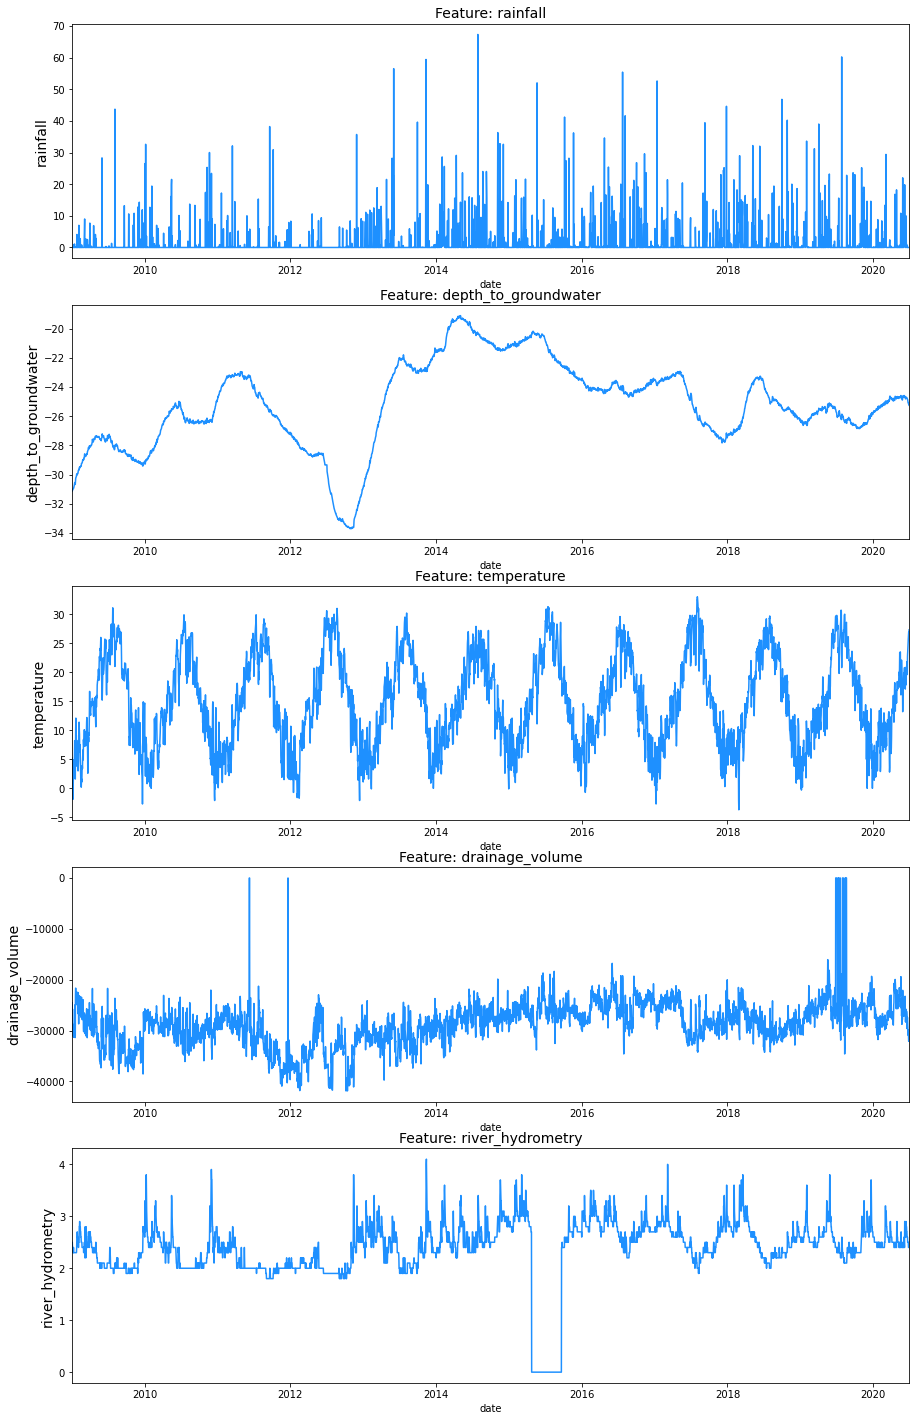

In [ ]:
# Na값 ffill로 채움
f, ax = plt.subplots(nrows=5, ncols = 1, figsize=(15,25))

for i, column in enumerate(df.drop('date',axis=1).columns):
  sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
  ax[i].set_title('Feature: {}'.format(column), fontsize=14)
  ax[i].set_ylabel(ylabel=column, fontsize=14)
  ax[i].set_xlim([date(2009,1,1), date(2020,6,30)])

**2. Data Preprocessing**

In [ ]:
df = df.sort_values(by='date')

# 간격 확인
df['delta'] = df['date'] - df['date'].shift(1)

df[['date','delta']].head()

,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [ ]:
df['delta'].sum(), df['delta'].count()

(Timedelta('4198 days 00:00:00'), 4198)

In [ ]:
df.shape

(4199, 7)

Missing Data 처리

In [ ]:
df = df.drop('delta', axis=1)
df.isnull().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

(733408.0, 737606.0)

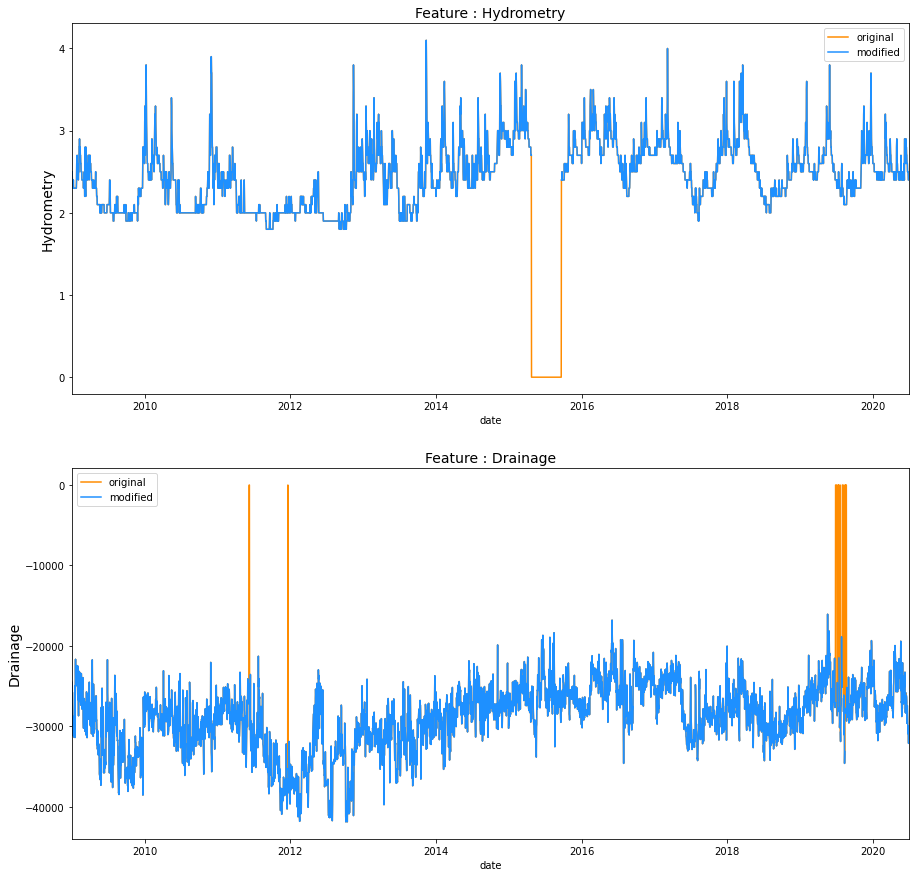

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,15))

old_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_hydrometry, ax=ax[0], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[0], color='dodgerblue',label='modified')
ax[0].set_title('Feature : Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)
ax[0].set_xlim([date(2009,1,1), date(2020,6,30)])

old_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_drainage, ax= ax[1], color='darkorange' , label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature : Drainage', fontsize=14)
ax[1].set_ylabel(ylabel='Drainage', fontsize=14)
ax[1].set_xlim([date(2009,1,1), date(2020,6,30)])

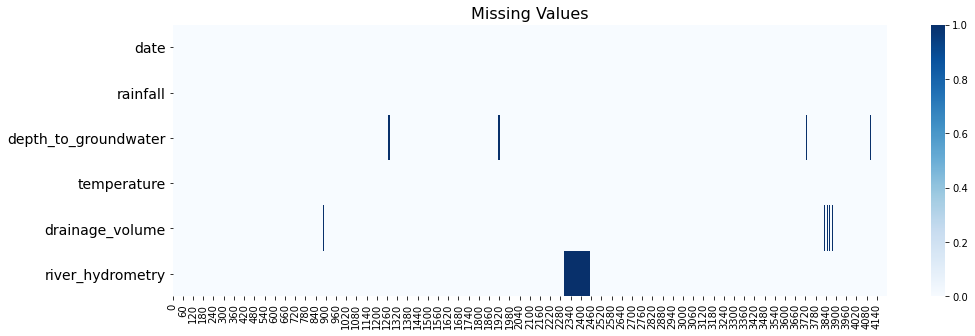

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

# 플롯에서 선택된 몇 가지 눈금 레이블 수정시
for tick in ax.yaxis.get_major_ticks():
  tick.label.set_fontsize(14)
plt.show()

- Option 1: Fill NaN with Outlier or Zero
- Option 2: Fill NaN with Mean Value
- Option 3: Fill NaN with Last Value with .ffill()
- Option 4: Fill NaN with Linearly Interpolated Value with .interpolate()

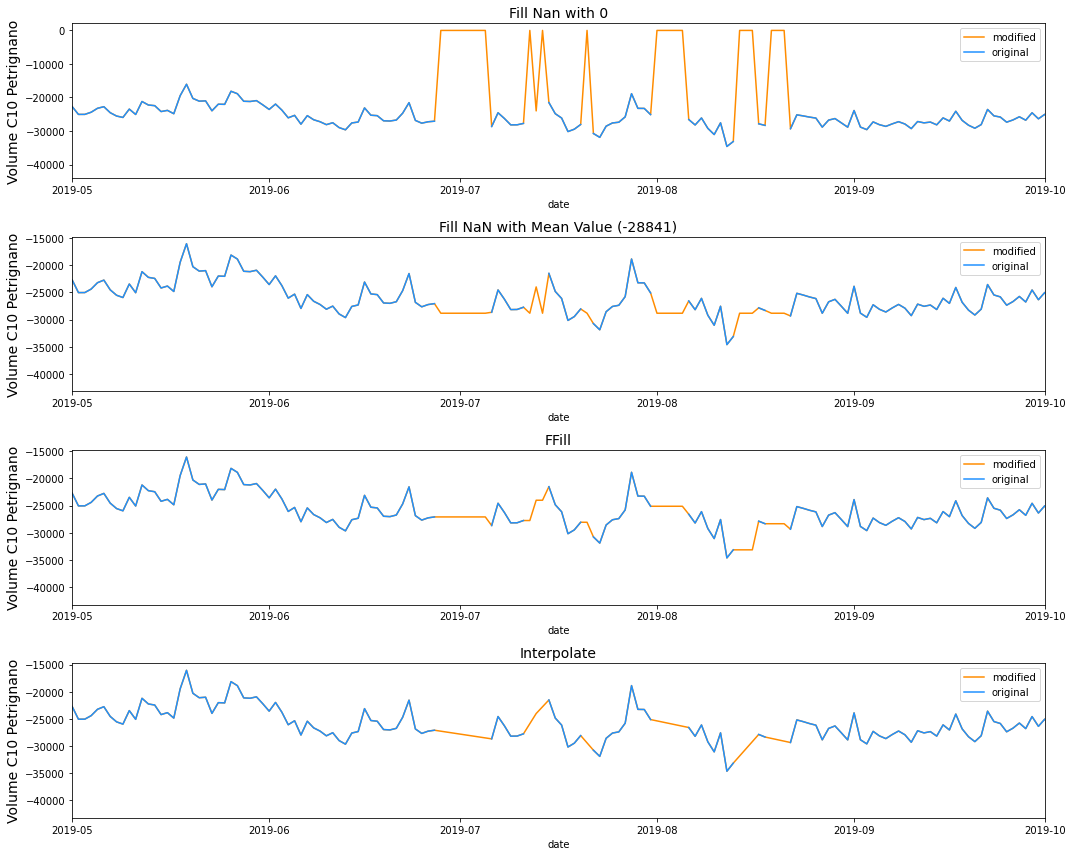

In [ ]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15,12))

# Option 1
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(0), ax=ax[0], color='darkorange', label='modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax =ax[0], color='dodgerblue', label='original')
ax[0].set_title('Fill Nan with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

# Option 2
mean_drainage = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

# Option 3
sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

# Option 4
sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
  ax[i].set_xlim([date(2019,5,1), date(2019,10,1)])

plt.tight_layout()
plt.show()

In [ ]:
# best option -> interpolate
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

Smoothing data / Resampling
- Resampling - 데이터에 대한 추가 정보 제공
- ex) Upsampling, Downsampling 등이 있다.
- 여기서는 downsampling 사용 (groupby나 평균집계와 비슷)

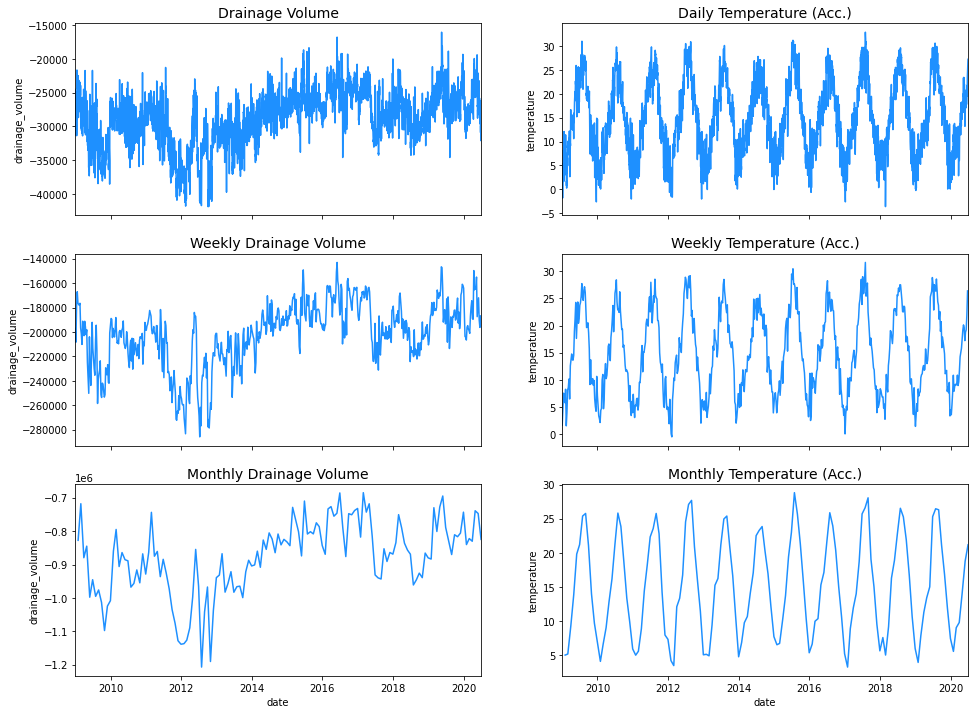

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))
# shareX=True 일때, 각 그래플들이 x축의 범위를 모두 같이 공유함

sns.lineplot(df['date'], df['drainage_volume'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Drainage Volume', fontsize=14)

# 7일 단위 합계
resampled_df = df[['date','drainage_volume']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['drainage_volume'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Drainage Volume', fontsize=14)

# 1달 단위 합계
resampled_df = df[['date','drainage_volume']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['drainage_volume'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Drainage Volume', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(df['date'], df['temperature'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df = df[['date','temperature']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['temperature'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df = df[['date','temperature']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['temperature'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

In [ ]:
# 추이의 변화가 적은 주단위로 다운 샘플링
downsample = df[['date',
                 'depth_to_groundwater',
                 'temperature'
                 ,'drainage_volume'
                 ,'river_hydrometry',
                 'rainfall']].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()                 

Stationarity
- 상수 평균 및 평균은 시간에 종속적이지 않다.
- 상수 분산 및 분산은 시간에 종속적이지 않다.
- 상수 공분산 및 공분산은 시간에 종속적이지 않다.

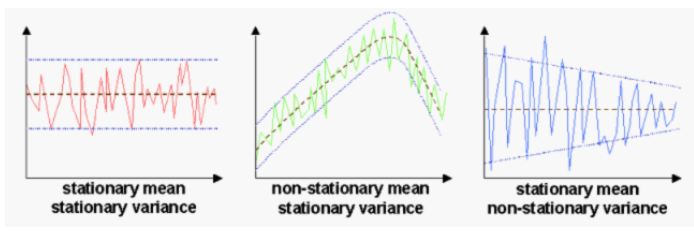


정상성 확인하는 3가지 방법
- 시각적 : 시계열 플로팅하고 추세또는 계절성 확인
- 기본 통계 : 시계열 분할하고 각 파티션 평균과 분산 비교
- 통계 테스트 : Augmented Dickey Fuller (ADF) 테스트



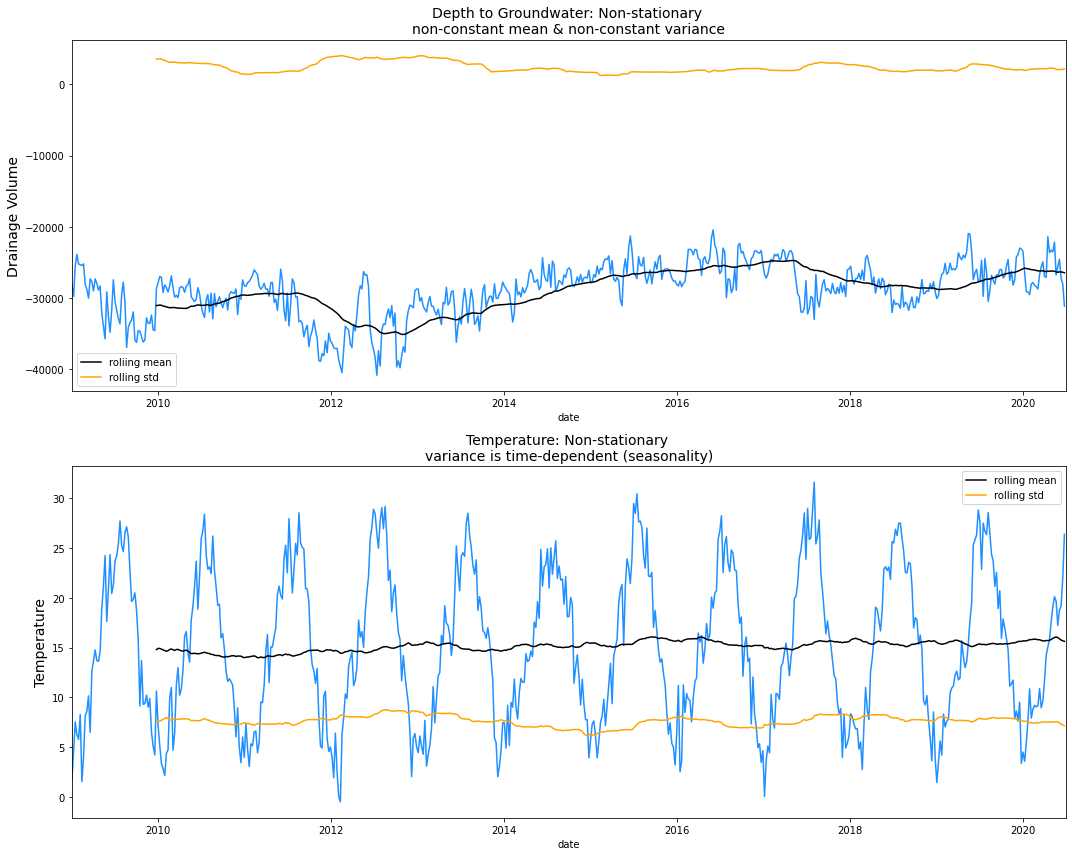

In [ ]:
# A year has 52 weeks (52 weeks * 7 days per week) aporx. 1년(=365의 근사치)

rolling_window = 52

f,ax = plt.subplots(nrows=2, ncols=1, figsize=(15,12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean(), # 앞에 52개의 평균
             ax=ax[0], color='black', label='roliing mean'
             )
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).std(),
             ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009,1,1), date(2020,6,30)])


sns.lineplot(x=df['date'], y=df['temperature'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

# 시각적 검사에서 특성에 일정한 평균과 표준이 없지만 거의 비슷하다는 것을 알 수 있다.

단위 루트 테스트
- 단위 루트는 시계열을 비정상 상태로 만드는 특성입니다. 
- ADF 테스트는 단위 루트 테스트에 속합니다

Augmented Dickey-Fuller (ADF)
- Null 가설(H0) : 시계열에는 단위근이 있다.(시계열은 고정되어 있지 않다.)
- 대체 가설(H1) : 시계열에는 단위근이 없다.
(시계열은 고정되어 있다. -> 시게열은 정상)

- 귀무가설을 기각하면 시계열이 정상이라는 결론

- 귀무가설 기각하는 방법
  - 1) p- 값이 설정된 유의 수준보다 낮 으면 귀무 가설을 기각 할 수 있습니다. 기본 유의 수준은 5 %입니다.
    - p- 값 >   유의 수준 (기본값 : 0.05) ** : 귀무 가설 (H0)을 기각하지 못했습니다. 데이터에 단위근이 있고 비정상입니다.
    - p- 값 <= 유의 수준 (기본값 : 0.05) ** : 귀무 가설 (H0)을 기각합니다. 데이터에 단위근이없고 정상입니다.
  - 2) 검정 통계량이 임계 값보다 작 으면 귀무 가설이 기각 될 수 있습니다.
    - ADF 통계 > 임계 값 ** : 귀무 가설 (H0)을 기각하지 못했습니다. 데이터에 단위근이 있고 비정상입니다.
    - ADF 통계 < 임계 값 ** : 귀무 가설 (H0)을 기각합니다. 데이터에 단위근이없고 고정되어 있습니다.


In [ ]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['depth_to_groundwater'].values)
result

(-2.880201649316664,
 0.047699190920208426,
 7,
 592,
 {'1%': -3.441444394224128,
  '10%': -2.569376663737217,
  '5%': -2.8664345376276454},
 -734.3154255877625)

In [ ]:
# 2가지 파악
# p-value가 0.05보다 작은지
# critical_values와 비교하여 ADF 통계 범위 확인

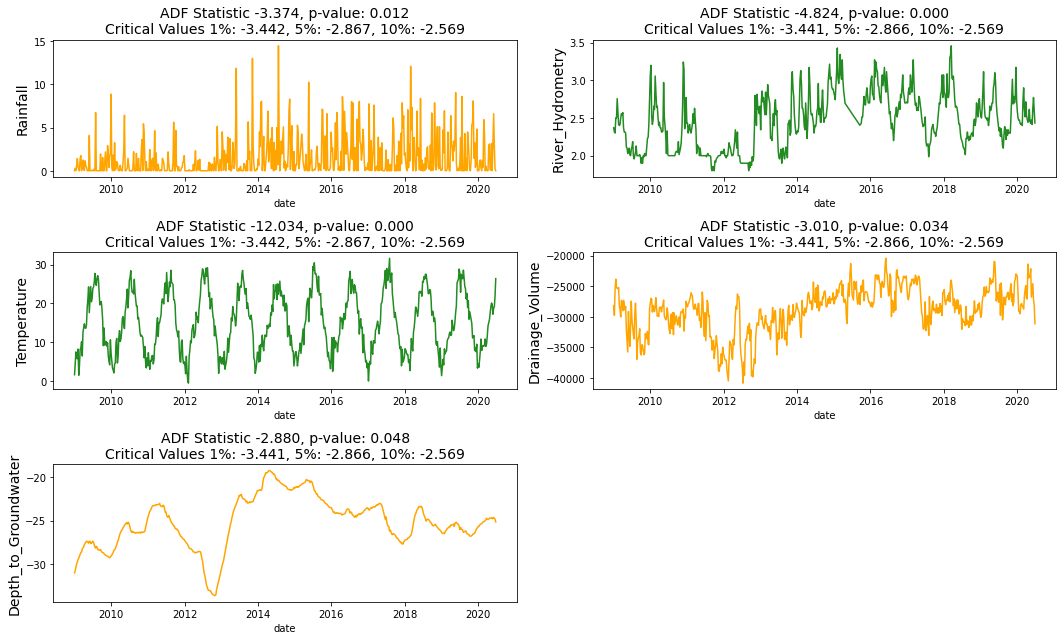

In [ ]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,9))

def visualize_adfuller_results(series, title, ax):
  result = adfuller(series)
  significance_level = 0.05
  adf_stat = result[0]
  p_val = result[1]
  crit_val_1 = result[4]['1%']
  crit_val_5 = result[4]['5%']
  crit_val_10 = result[4]['10%']

  if (p_val < significance_level) & ((adf_stat < crit_val_1)):
    linecolor = 'forestgreen'
  elif (p_val < significance_level) & (adf_stat < crit_val_5):
    linecolor = 'orange'
  elif (p_val < significance_level) & (adf_stat < crit_val_10):
    linecolor = 'red'
  else:
    linecolor = 'purple'
  sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
  ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
  ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df['temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df['river_hydrometry'].values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1]) # Remove the Axes ax from the figure and update the current axes.
plt.tight_layout()
plt.show()

# 데이터가 고정되어 있지 않지만 ARIMA와 같은 모델 (이 특성이 필요함)을 사용하려면 데이터를 변환해야합니다.

# 시리즈를 정상 성 시리즈로 변환하는 가장 일반적인 두 가지 방법은 다음과 같습니다.
# 변환 : 예 : 상수가 아닌 분산을 안정화하기위한 로그 또는 제곱근
# 차이 : 이전 값에서 현재 값을 뺍니다

Transforming

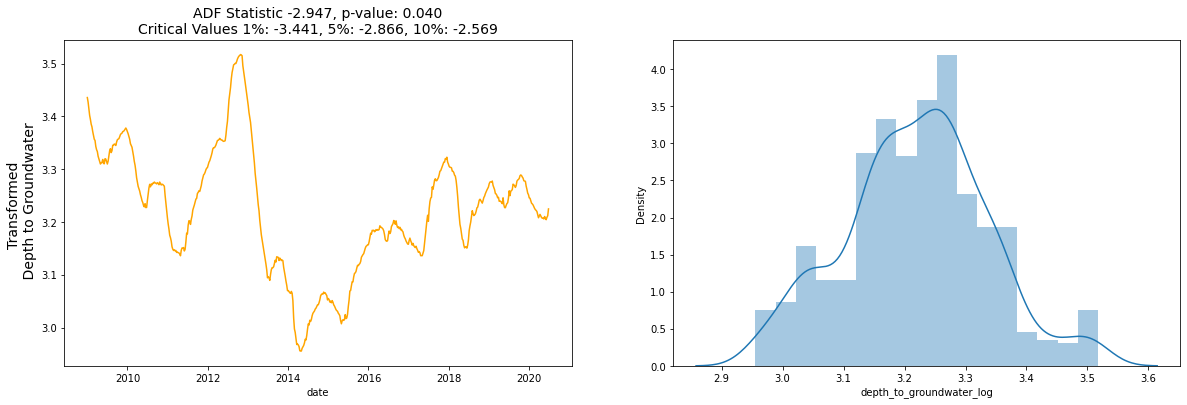

In [ ]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)

df['depth_to_groundwater_log'] = np.log(abs(df['depth_to_groundwater']))

f,ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
visualize_adfuller_results(df['depth_to_groundwater_log'], 'Transformed \n Depth to Groundwater', ax[0])

sns.distplot(df['depth_to_groundwater_log'], ax = ax[1])

Differencing - 차분

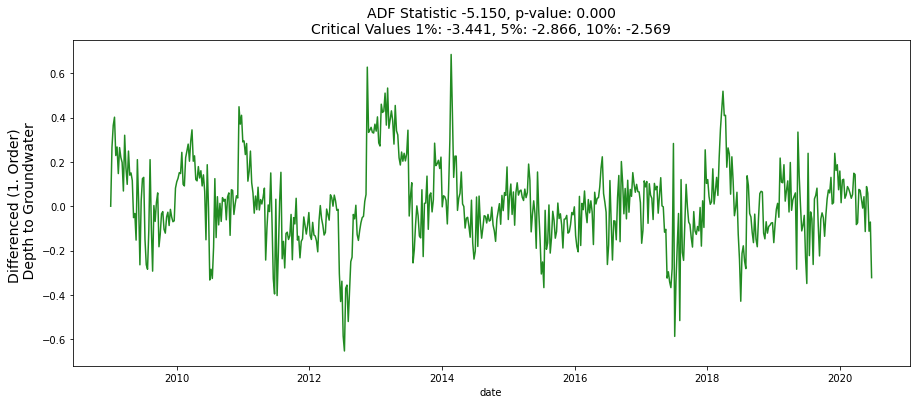

In [ ]:
# First Order Differencing
ts_diff = np.diff(df['depth_to_groundwater'])

# 차분하면 (600,) -> (599,)가 된다. => 앞에 0을 더해서 (600,)로 형태 맞춰준다.
df['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['depth_to_groundwater_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', ax)

**3. Feature Engineering**

In [ ]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1,1
1,2009-01-08,2009,1,8,8,2,1,1
2,2009-01-15,2009,1,15,15,3,1,1
3,2009-01-22,2009,1,22,22,4,1,1
4,2009-01-29,2009,1,29,29,5,1,1


Encoding Cyclical Features

The new time features are cyclical. For example,the feature month cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the month feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot of models.

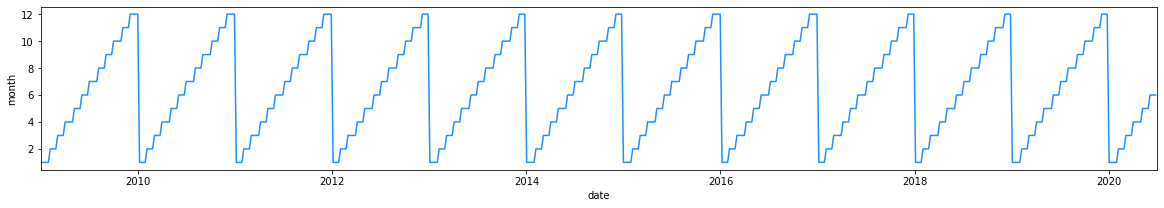

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='dodgerblue')
ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

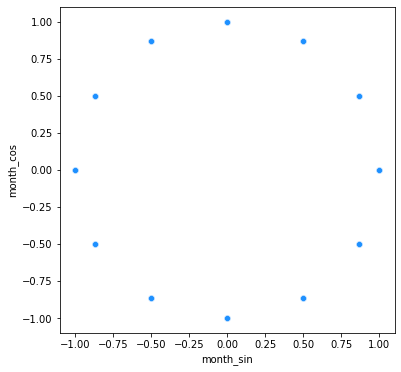

In [ ]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

TimeSeries Decomposition

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

These components are defined as follows:

- Level: The average value in the series.
- Trend: The increasing or decreasing value in the  series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively:

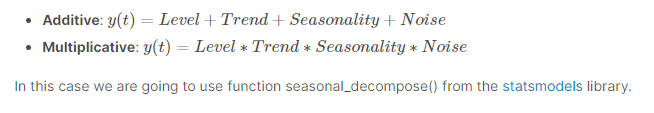

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'rainfall', 'temperature', 'drainage_volume', 
    'river_hydrometry', 'depth_to_groundwater'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], freq=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

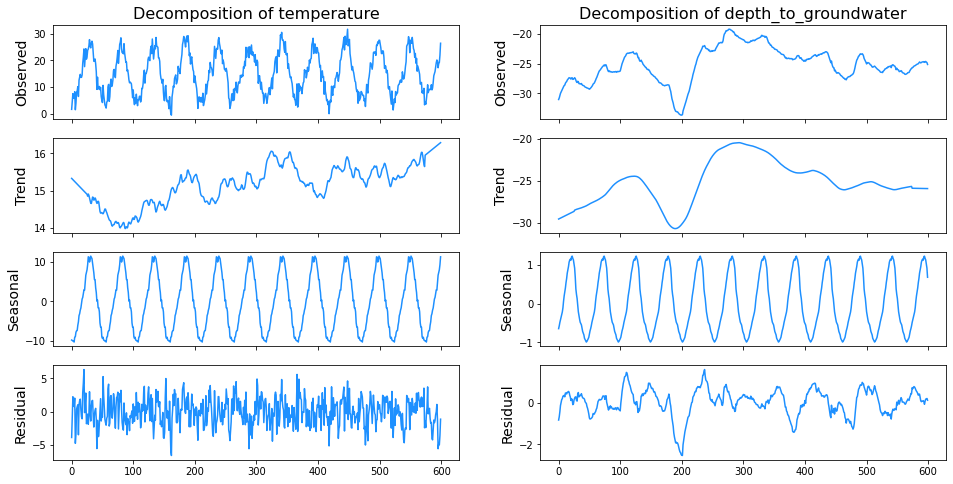

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['temperature','depth_to_groundwater']):

  res = seasonal_decompose(df[column], freq=52, model='additive', extrapolate_trend='freq')

  ax[0, i].set_title('Decomposition of {}'.format(column), fontsize=16)
  res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
  ax[0, i].set_ylabel('Observed', fontsize=14)

  res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
  ax[1,i].set_ylabel('Trend', fontsize=14)

  res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
  ax[2,i].set_ylabel('Seasonal', fontsize=14)

  res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
  ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

Lag

In [ ]:
# 다른 변수와의 상관 관계를 비교하기 위해 shift () (lag)를 사용하여 각 변수를 계산

In [ ]:
weeks_in_month = 4

for column in core_columns:
  # 이전 달들
  df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
  df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)

  # 다음 달들
  df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
  df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
  df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

**4. Exploratory Data Analysis**

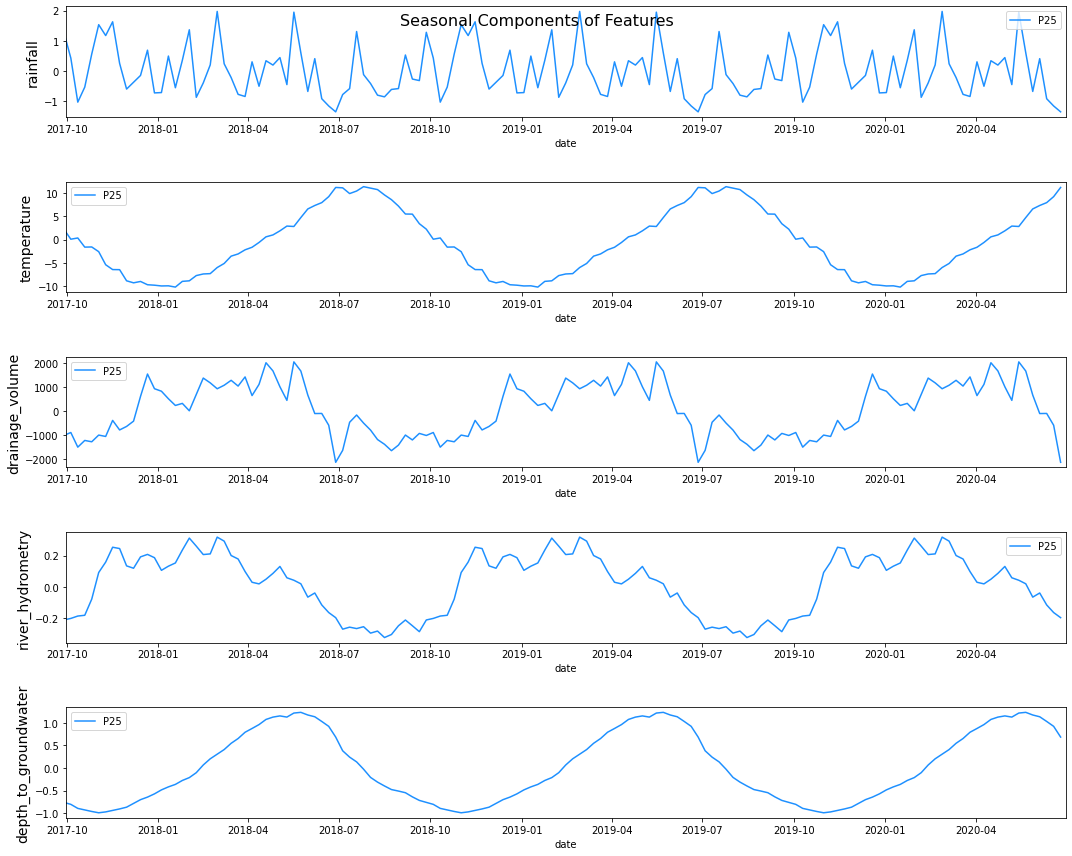

In [ ]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

알수있는 결과 

- depth_to_groundwater : 5 월 / 6 월경에 최대에 도달하고 11 월경에 최소값에 도달
- 온도 : 8 월경에 최고치에 도달하고 1 월경에 최저 기온에 도달
- drainage_volume : 7 월경에 최저치에 도달합니다.
- river_hydrometry : 2 월 / 3 월경에 최대치에 도달하고 9 월경에 최소값에 도달

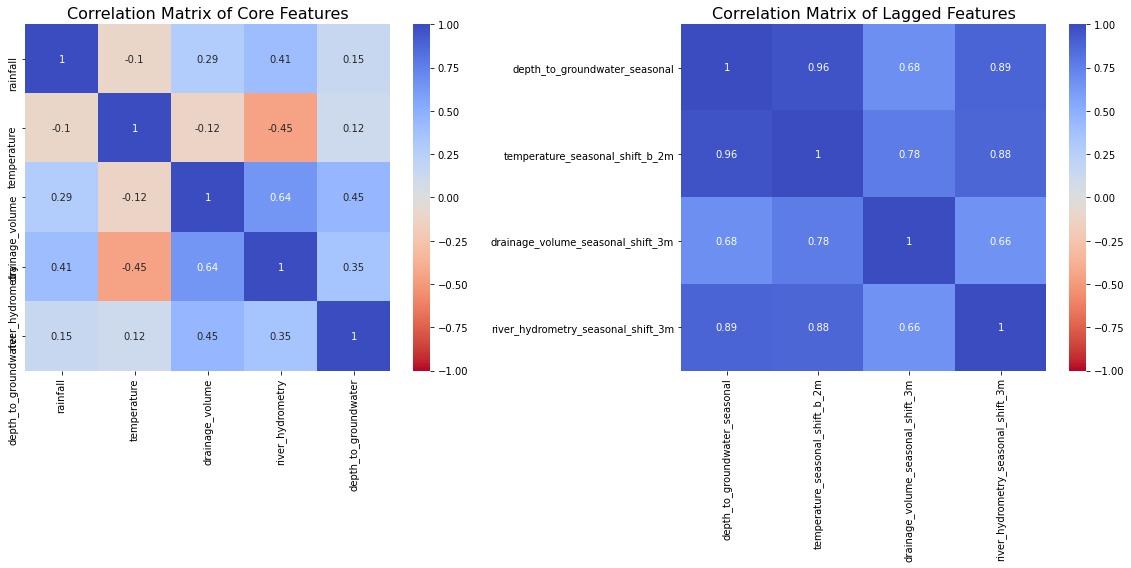

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'depth_to_groundwater_seasonal',  
    # 'rainfall_seasonal_shift_2m',       
    'temperature_seasonal_shift_b_2m',
    'drainage_volume_seasonal_shift_3m', 
    'river_hydrometry_seasonal_shift_3m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

# 원래의 것보다 시프트 된 기능 (지연된 기능)의 경우 더 높은 상관 관계를 보입니다.

Autocorrelation Analysis

ACF and PACF plots: After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. Of course, with software like Statgraphics, you could just try some different combinations of terms and see what works best. But there is a more systematic way to do this. By looking at the autocorrelation function (ACF) and partial autocorrelation (PACF) plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

- Autocorrelation Function (ACF): P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter
- Partial Autocorrelation Function (PACF): D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

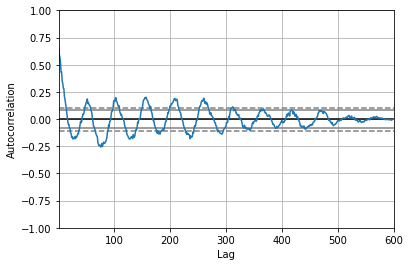

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['depth_to_groundwater_diff_1'])
plt.show()

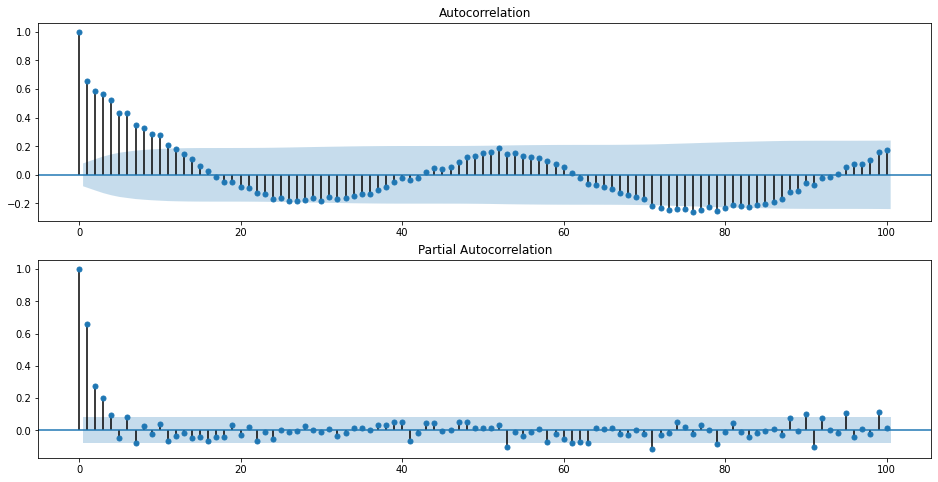

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[1])

plt.show()

**5. Modeling**

Time series can be either univariate or multivariate:

- Univariate time series only has a single time-dependent variable.
- Multivariate time series have a multiple time-dependent variable.

But, first of all we are going to see how does cross-validation technic works in TimeSeries Analysis.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['depth_to_groundwater']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

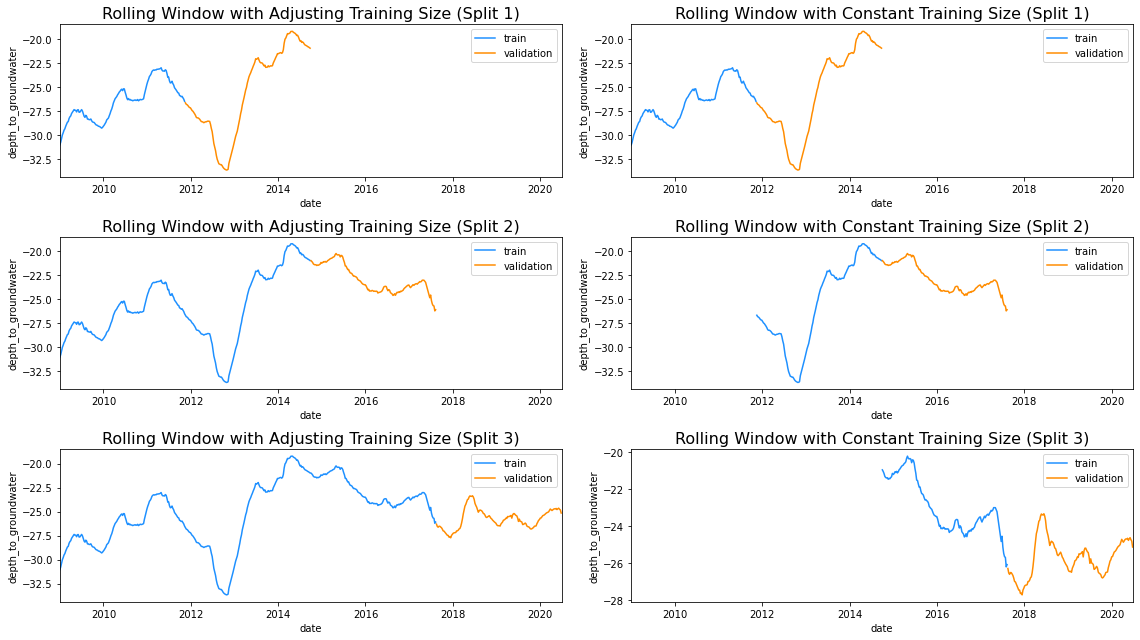

In [ ]:
f, ax  = plt.subplots(nrows= N_SPLITS, ncols=2, figsize=(16,9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

# 각 플롯에서 모델을 맞추기 위해 사용하는 훈련 및 테스트 세트를 이해하는 도움을 준다.

Models for Univariate Time Series

First of all, we are going to analize univariate TimeSeries forecasting.

- Univariate time series: Only one variable is varying over time. For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature.

In [ ]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


Prophet Model

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from fbprophet import Prophet


# Train the model
model = Prophet()
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print('RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 1.199099789648606


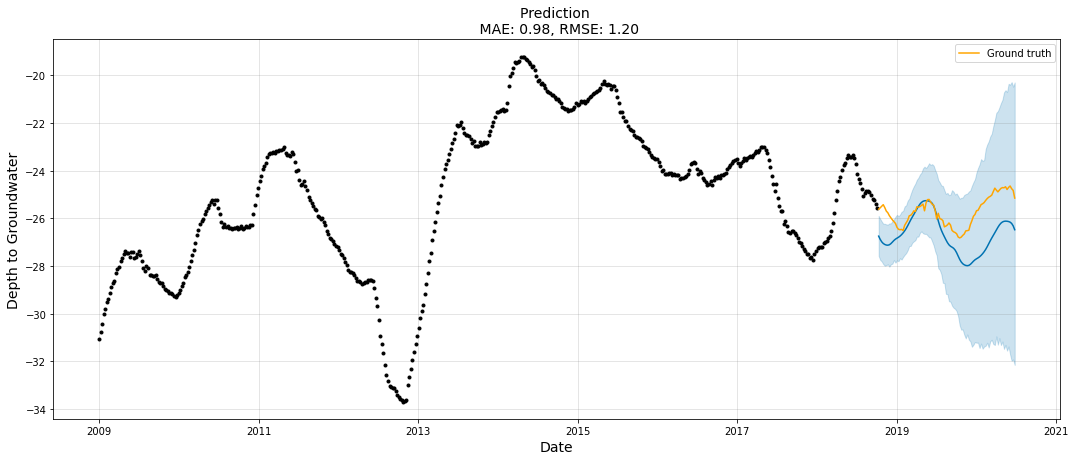

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

ARIMA

자동 회귀 통합 이동 평균 (ARIMA) 모델은 데이터의 자기 상관을 설명합니다. 이 모델은 시계열이 정상이라고 가정합니다. 세 가지 주요 부분으로 구성됩니다.

ARIMA( p, d, q)

- p: Lag order (reference PACF in Autocorrelation Analysis) - 지연순서
- d: Degree of differencing. (reference Differencing in Stationarity) 
- q: Order of moving average (check out ACF in Autocorrelation Analysis) - 이동평균순서

Steps to analyze ARIMA

- 1 단계 — 정상 성 확인 : 시계열에 추세 또는 계절성 구성 요소가있는 경우 ARIMA를 사용하여 예측하기 전에 시계열을 고정해야합니다. .
- 2 단계 — 차이 : 시계열이 정상적이지 않은 경우 차이를 통해 정상화되어야합니다. 첫 번째 차이를 취한 다음 정상 성을 확인하십시오. 필요한만큼 차이를 가져라. 계절별 차이도 확인하십시오.
- 3 단계 — 검증 샘플 필터링 : 모델이 얼마나 정확한지 검증하는 데 사용됩니다. 이를 위해 train test validation split 사용하십시오.
- 4 단계 — AR 및 MA 용어 선택 : ACF 및 PACF를 사용하여 AR 용어, MA 용어 또는 둘 다를 포함할지 여부를 결정합니다.
- 5 단계 — 모델 구축 : 모델을 구축하고 예측할 기간 수를 N으로 설정합니다 (요구 사항에 따라 다름).
- 6 단계 — 모델 검증 : 예측 값을 검증 샘플의 실제 값과 비교합니다.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# Fit model
model = ARIMA(y_train, order = (1,1,1))
model_fit = model.fit()

# Predict
y_pred, se, conf = model_fit.forecast(90)

# Calculate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 0.885824391105992


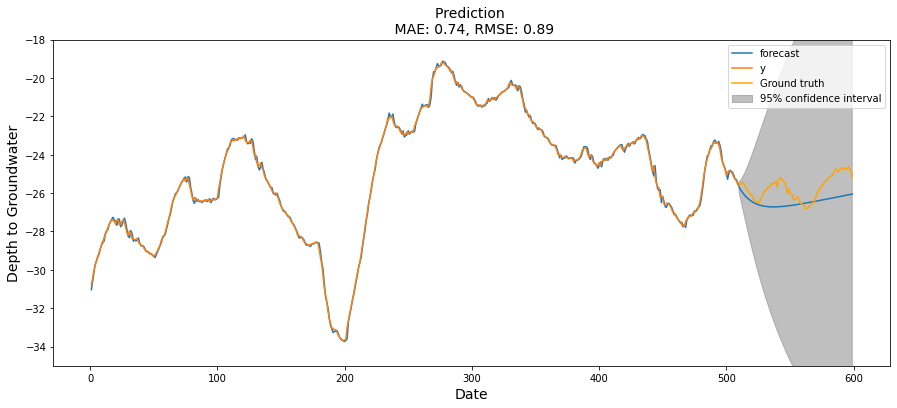

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model_fit.plot_predict(1, 599, ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

ax.set_ylim(-35, -18)
plt.show()

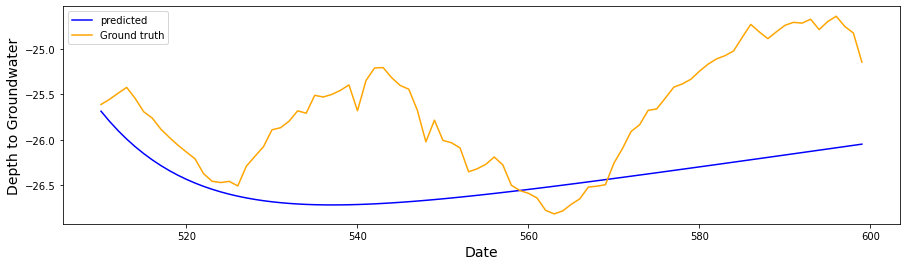

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted')
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

Auto-ARIMA

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-631.136, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-242.692, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-574.047, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-427.347, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-243.054, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-629.209, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-629.237, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-492.779, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-611.065, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-628.351, Time=0.74 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-632.995, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-428.258, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-575.735, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-631.069, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]          

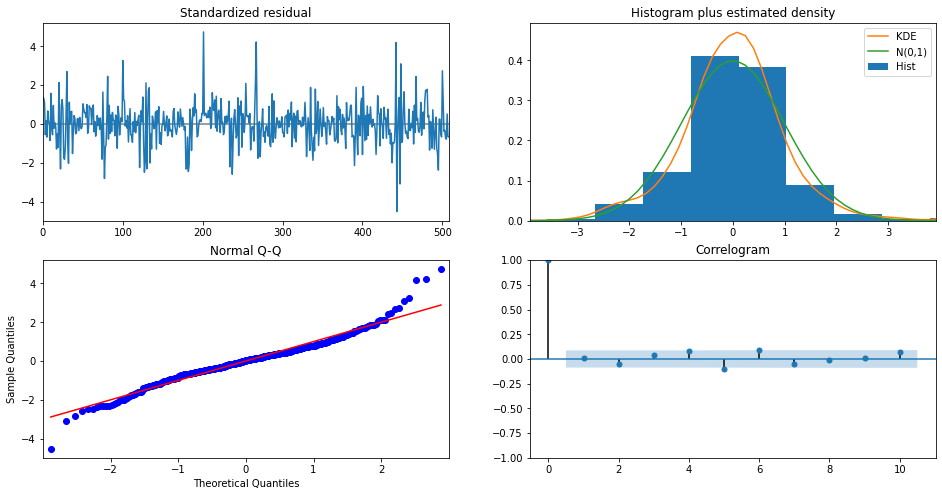

In [ ]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

- 왼쪽 상단 : 잔차 오차는 평균 0 주변에서 변동하는 것처럼 보이며 (-4, 4) 사이에 균일 한 분산이 있습니다.

- 오른쪽 위 : 밀도 플롯은 평균이 0 인 정규 분포를 제안합니다.

- 왼쪽 하단 : 파란색 점의 대부분이 빨간색 선 위에 있으므로 분포가 매우 낮게 치우쳐있는 것 같습니다 (나에게 비뚤어지지 않음). -> 정상성 만족

- 오른쪽 하단 : Correlogram, aka, ACF 플롯은 잔차 오류가 자기 상관이 아님을 보여줍니다.

LSTM

The following data pre-processing and feature engineering need to be done before construct the LSTM model.

- Create the dataset, ensure all data is float.
- Normalize the features.
- Split into training and test sets.
- Convert an array of values into a dataset matrix.
- Reshape into X=t and Y=t+1.
- Reshape input to be 3D (num_samples, num_timesteps, num_features).

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])

# Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range = (-1,0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.81796644],
       [-0.79970385],
       [-0.7745311 ],
       [-0.74679171],
       [-0.73099704],
       [-0.71253702],
       [-0.7023692 ],
       [-0.68410661],
       [-0.66890424],
       [-0.65528134]])

In [ ]:
# Defines the rolling window
look_back = 52

# split train / test
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
  X, Y = [], []
  for i in range(look_back, len(dataset)):
    a = dataset[i-look_back:i, 0]
    X.append(a)
    Y.append(dataset[i,0])
  return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# print(x_train.shape)

# reshape input to be [samples, time_steps, feature]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

406 90


In [ ]:
x_train.shape, x_test.shape

((406, 1, 52), (90, 1, 52))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Epoch 1/5
406/406 [==============================] - 4s 4ms/step - loss: 0.0241 - val_loss: 0.0039
Epoch 2/5
406/406 [==============================] - 1s 3ms/step - loss: 0.0029 - val_loss: 4.5642e-04
Epoch 3/5
406/406 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 5.5075e-04
Epoch 4/5
406/406 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 5/5
406/406 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 5.8059e-04
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 128)            92672     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1625      
_________

In [ ]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# print(train_predict, test_predict)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

# print(train_predict, test_predict)

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print( 'RMSE: {}'.format(score_rmse))

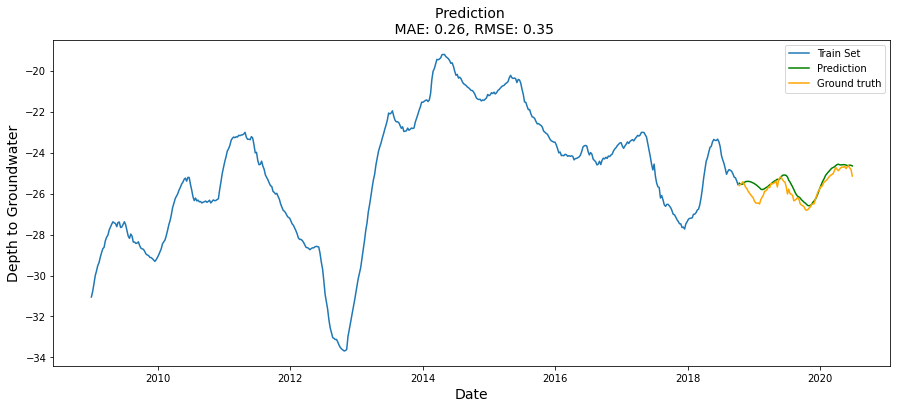

In [ ]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

Models for Multivariate Time Series

- Multivariate time series: Multiple variables are varying over time. For example, a tri-axial accelerometer. There are three accelerations, one for each axis (x,y,z) and they vary simultaneously over time.

In [ ]:
feature_columns = [
    'rainfall',
    'temperature',
    'drainage_volume',
    'river_hydrometry',
]
target_column = ['depth_to_groundwater']

train_size = int(0.85 * len(df))

multivariate_df = df[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,rainfall,temperature,drainage_volume,river_hydrometry
0,2009-01-01,-31.048571,0.000000,1.657143,-28164.918857,2.371429
1,2009-01-08,-30.784286,0.285714,4.571429,-29755.789714,2.314286
2,2009-01-15,-30.420000,0.028571,7.528571,-25463.190857,2.300000
3,2009-01-22,-30.018571,0.585714,6.214286,-23854.422857,2.500000
4,2009-01-29,-29.790000,1.414286,5.771429,-25210.532571,2.500000


Multivariate Prophet

In [ ]:
from fbprophet import Prophet


# Train the model
model = Prophet()
model.add_regressor('rainfall')
model.add_regressor('temperature')
model.add_regressor('drainage_volume')
model.add_regressor('river_hydrometry')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 0.98605259398341


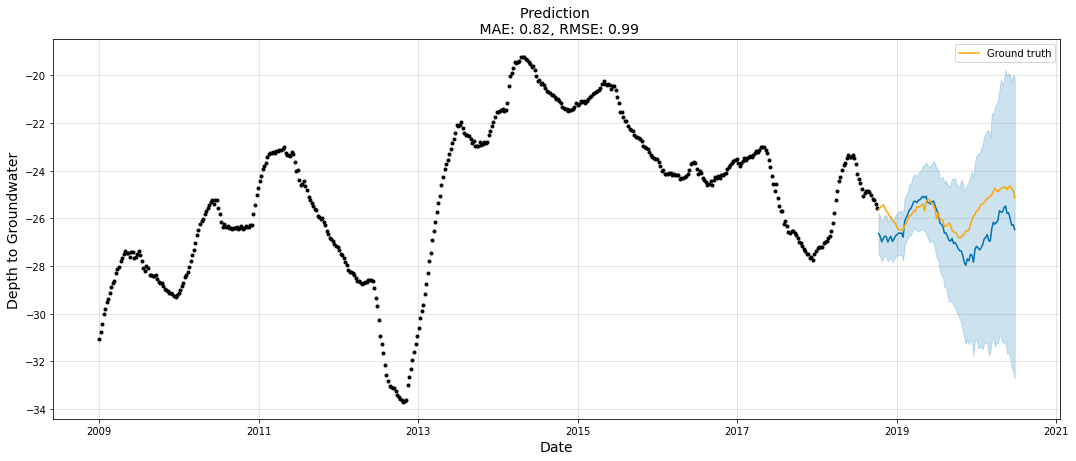

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

**6. Conclusion**
- the best results are taken from Univariate LSTM (with rolling window of 1 year) and multi-variate Prophet.